In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
pd.set_option('mode.chained_assignment',  None)
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거


In [2]:
train_data = pd.read_csv('train_merge_data.csv')
test_data = pd.read_csv('test_merge_data.csv')

C:\Users\82104\AppData\Local\Temp\ipykernel_1760\1944733010.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_merge_data.csv')


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 24 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   id            int64  
 2   date          object 
 3   store_nbr     int64  
 4   family        object 
 5   sales         float64
 6   onpromotion   int64  
 7   dcoilwtico    float64
 8   type_x        object 
 9   locale        object 
 10  locale_name   object 
 11  description   object 
 12  transferred   object 
 13  transactions  float64
 14  city          object 
 15  state         object 
 16  type_y        object 
 17  cluster       int64  
 18  Year          int64  
 19  Month         int64  
 20  Weekend       int64  
 21  Weekday       int64  
 22  trend         int64  
 23  NewYearsDay   bool   
dtypes: bool(1), float64(3), int64(10), object(10)
memory usage: 538.9+ MB


### feature
- date : 날짜
- store_nbr : store number
- family : 물건 종류
- onpromotion : 프로모션 행사 제품 수
- dcoilwtico : oil가격
- type_x : holiday type
  - ['Holiday', 'Empty', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge']
- locale : holiday가 적용되는 범위
  - ['National', 'Empty', 'Local', 'Regional']
- locale_name : holiday가 적용되는 지역명
  - ['Ecuador', 'Empty', 'Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda', 'Imbabura', 'Machala', 'Latacunga','El Carmen', 'Santo Domingo', 'Cayambe', 'Guayaquil', 'Esmeraldas','Ambato', 'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas','Santa Elena', 'Quito', 'Loja', 'Salinas']
- description : holiday설명
- trasnferred : 연휴 이동 여부
- transactions : 거래량 (na값은 선형회귀모형으로 대체)
- city : store의 city
- state store의 주
- type_y : store의 type
- cluster : 소매점의 개수
- year : 연도
- Month :월 
- Weekend : 주말 여부
- Weekday : 요일 (월:0 ~ 일:6)
- trend
- NewYearsDay : 새해 여부

### target
- sales

In [4]:
train_data.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,...,city,state,type_y,cluster,Year,Month,Weekend,Weekday,trend,NewYearsDay
0,0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
1,1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
2,2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
3,3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
4,4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True


city가 state보다 더 작은 개념이기 때문에 state를 제거했다.

In [5]:
# city가 state보다 더 작은 개념. => state 제거
train_data.drop(columns = ['Unnamed: 0', 'id', 'description', 'state'], inplace = True)

우선 국가적인 행사는 휴일에 영향을 미치기 때문에 holiday 정보를 바로 모델에 사용하기 보다는 holiday에서 연휴가 된 날을 찾고자 했다. 따라서 National 정보만 남기고, 다른 날로 대체된 날도 제거한 뒤, type_x가 'holiday', 'additional', 'bridge'인 날만 남겼다. 이를 holiday라는 열로 만들고, 기존의 weekend(주말) column과 or 연산을 통해 no_work_day column을 만들었다. 그 뒤 holiday와 관련된 columns을 모두 drop 시켰다. test_data의 경우 위의 과정을 거쳤을 때 모든 열이 Empty가 되었기 때문에 weekend를 그대로 no_work_day로 이용했다.

In [6]:
# National인 holiday 정보만 남긴다.
mask = (train_data.locale != 'National')
train_data.type_x[mask] = 'Empty'
train_data.locale[mask] = 'Empty'
train_data.locale_name[mask] = 'Empty'
train_data.transferred[mask] = 'Empty'

mask = (test_data.locale != 'National')
test_data.type_x[mask] = 'Empty'
test_data.locale[mask] = 'Empty'
test_data.locale_name[mask] = 'Empty'
test_data.transferred[mask] = 'Empty'

In [7]:
mask = (train_data.transferred == 'True') # 다른날로 대체됨.
train_data.type_x[mask] = 'Empty'
train_data.locale[mask] = 'Empty'
train_data.locale_name[mask] = 'Empty'
train_data.transferred[mask] = 'Empty'

mask = (test_data.transferred == 'True')
test_data.type_x[mask] = 'Empty'
test_data.locale[mask] = 'Empty'
test_data.locale_name[mask] = 'Empty'
test_data.transferred[mask] = 'Empty'

In [8]:
train_data.transferred[train_data.transferred != 'Empty'] = 'False'
test_data.transferred[test_data.transferred != 'Empty'] = 'False'

In [9]:
# 쉬는 날: holiday, additional, bridge
mask = ((train_data.type_x == 'Holiday') | (train_data.type_x == 'Additional') | (train_data.type_x == 'Bridge'))

In [10]:
# 주말이거나 holiday인 날을 no_work_day로 지정
train_data['no_work_day'] = train_data['Weekend'] | mask

In [11]:
train_data.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,transferred,...,city,type_y,cluster,Year,Month,Weekend,Weekday,trend,NewYearsDay,no_work_day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,False,...,Quito,D,13,2013,1,0,1,0,True,True
1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,False,...,Quito,D,13,2013,1,0,1,0,True,True
2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,False,...,Quito,D,13,2013,1,0,1,0,True,True
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,False,...,Quito,D,13,2013,1,0,1,0,True,True
4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,False,...,Quito,D,13,2013,1,0,1,0,True,True


In [12]:
test_data.head()

,Unnamed: 0,id,date,store_nbr,family,onpromotion,dcoilwtico,type_x,locale,locale_name,...,city,state,type_y,cluster,Year,Month,Weekend,Weekday,trend,NewYearsDay
0,0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,Empty,Empty,Empty,...,Quito,Pichincha,D,13,2017,8,0,2,1688,False
1,1,3000889,2017-08-16,1,BABY CARE,0,46.8,Empty,Empty,Empty,...,Quito,Pichincha,D,13,2017,8,0,2,1688,False
2,2,3000890,2017-08-16,1,BEAUTY,2,46.8,Empty,Empty,Empty,...,Quito,Pichincha,D,13,2017,8,0,2,1688,False
3,3,3000891,2017-08-16,1,BEVERAGES,20,46.8,Empty,Empty,Empty,...,Quito,Pichincha,D,13,2017,8,0,2,1688,False
4,4,3000892,2017-08-16,1,BOOKS,0,46.8,Empty,Empty,Empty,...,Quito,Pichincha,D,13,2017,8,0,2,1688,False


In [13]:
train_data.drop(columns = ['type_x', 'locale', 'locale_name', 'transferred', 'Weekend'], inplace = True)
test_data.drop(columns = ['Unnamed: 0', 'id', 'type_x', 'locale', 'locale_name', 'description', 'transferred','state'], inplace = True)

In [14]:
test_data.rename(columns = {'Weekend':'no_work_day'}, inplace = True)



---



In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   dcoilwtico    float64
 6   transactions  float64
 7   city          object 
 8   type_y        object 
 9   cluster       int64  
 10  Year          int64  
 11  Month         int64  
 12  Weekday       int64  
 13  trend         int64  
 14  NewYearsDay   bool   
 15  no_work_day   bool   
dtypes: bool(2), float64(3), int64(7), object(4)
memory usage: 332.1+ MB


In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          28512 non-null  object 
 1   store_nbr     28512 non-null  int64  
 2   family        28512 non-null  object 
 3   onpromotion   28512 non-null  int64  
 4   dcoilwtico    28512 non-null  float64
 5   transactions  28512 non-null  float64
 6   city          28512 non-null  object 
 7   type_y        28512 non-null  object 
 8   cluster       28512 non-null  int64  
 9   Year          28512 non-null  int64  
 10  Month         28512 non-null  int64  
 11  no_work_day   28512 non-null  int64  
 12  Weekday       28512 non-null  int64  
 13  trend         28512 non-null  int64  
 14  NewYearsDay   28512 non-null  bool   
dtypes: bool(1), float64(2), int64(8), object(4)
memory usage: 3.1+ MB


In [17]:
train_data.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,city,type_y,cluster,Year,Month,Weekday,trend,NewYearsDay,no_work_day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,1420.876311,Quito,D,13,2013,1,1,0,True,True
1,2013-01-01,1,BABY CARE,0.0,0,93.14,1420.876311,Quito,D,13,2013,1,1,0,True,True
2,2013-01-01,1,BEAUTY,0.0,0,93.14,1420.876311,Quito,D,13,2013,1,1,0,True,True
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,1420.876311,Quito,D,13,2013,1,1,0,True,True
4,2013-01-01,1,BOOKS,0.0,0,93.14,1420.876311,Quito,D,13,2013,1,1,0,True,True


In [18]:
test_data.head()

,date,store_nbr,family,onpromotion,dcoilwtico,transactions,city,type_y,cluster,Year,Month,no_work_day,Weekday,trend,NewYearsDay
0,2017-08-16,1,AUTOMOTIVE,0,46.8,1448.259579,Quito,D,13,2017,8,0,2,1688,False
1,2017-08-16,1,BABY CARE,0,46.8,1448.259579,Quito,D,13,2017,8,0,2,1688,False
2,2017-08-16,1,BEAUTY,2,46.8,1448.259579,Quito,D,13,2017,8,0,2,1688,False
3,2017-08-16,1,BEVERAGES,20,46.8,1448.259579,Quito,D,13,2017,8,0,2,1688,False
4,2017-08-16,1,BOOKS,0,46.8,1448.259579,Quito,D,13,2017,8,0,2,1688,False


#### city
- city 정보가 유용할까라는 의문이 듬. store_nbr에 어느정도 정보가 있지않을까? 사실 같은 도시라도 어느지역인지에 따라서 많이 달라지지 않을까라는 생각.

In [19]:
pd.pivot_table(train_data, index = 'store_nbr', columns = 'city', values = 'date', aggfunc = 'size')

city,Ambato,Babahoyo,Cayambe,Cuenca,Daule,El Carmen,Esmeraldas,Guaranda,Guayaquil,Ibarra,...,Loja,Machala,Manta,Playas,Puyo,Quevedo,Quito,Riobamba,Salinas,Santo Domingo
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56562.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56562.0,NaN,NaN,NaN


In [20]:
train_data.drop(columns = ['city'], inplace = True)
test_data.drop(columns = ['city'], inplace = True)

#### onpromotion

(array([6.09771e+05, 1.22670e+04, 3.25100e+03, 4.23000e+02, 2.60000e+01,
        1.20000e+01, 2.10000e+01, 1.10000e+01, 1.80000e+01, 2.00000e+01]),
 array([  1.,  75., 149., 223., 297., 371., 445., 519., 593., 667., 741.]),
 <BarContainer object of 10 artists>)

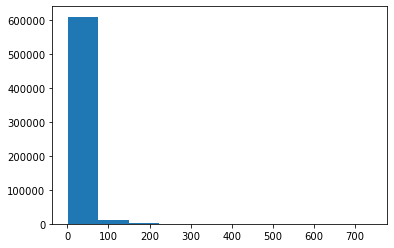

In [21]:
plt.hist(train_data.onpromotion[train_data.onpromotion != 0])

(array([449252.,  69026.,  32167.,  21180.,  15553.,  12039.,   7667.,
          5053.,   2917.,   1789.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <BarContainer object of 10 artists>)

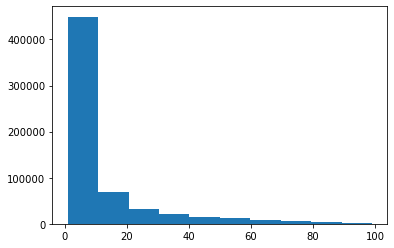

In [22]:
plt.hist(train_data.onpromotion[(train_data.onpromotion < 100) & (train_data.onpromotion !=0) ])

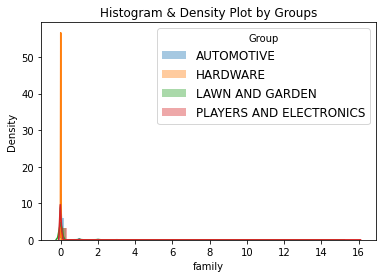

In [23]:
tool_list = ['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'] #4
for group in tool_list:
  subset = train_data[train_data['family'] == group]

  sns.distplot(subset['onpromotion'],
              hist = True,
              label = group)
  
plt.title('Histogram & Density Plot by Groups')
plt.xlabel('family')
plt.ylabel('Density')
plt.legend(prop = {'size': 12}, title = 'Group')
plt.show()

C:\Users\82104\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


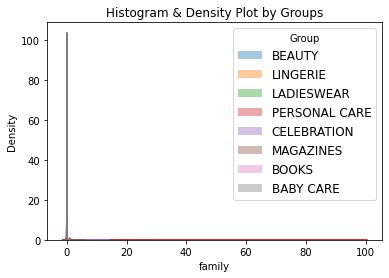

In [24]:
LifeStyle_list = ['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'] #8

for group in LifeStyle_list:
  subset = train_data[train_data['family'] == group]

  sns.distplot(subset['onpromotion'],
              hist = True,
              label = group)
  
plt.title('Histogram & Density Plot by Groups')
plt.xlabel('family')
plt.ylabel('Density')
plt.legend(prop = {'size': 12}, title = 'Group')
plt.show()

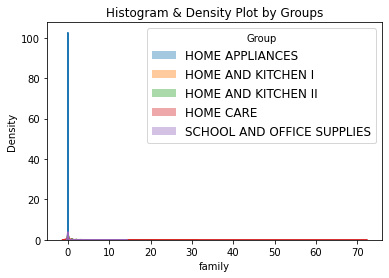

In [25]:
home_list = ['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES'] # 5

for group in home_list:
  subset = train_data[train_data['family'] == group]

  sns.distplot(subset['onpromotion'],
              hist = True,
              label = group)
  
plt.title('Histogram & Density Plot by Groups')
plt.xlabel('family')
plt.ylabel('Density')
plt.legend(prop = {'size': 12}, title = 'Group')
plt.show()

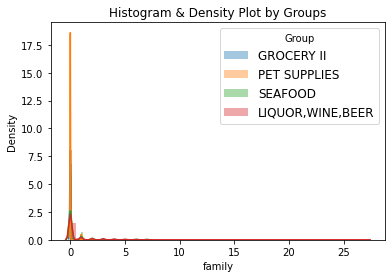

In [26]:
food_list = [ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER'] #4

for group in food_list:
  subset = train_data[train_data['family'] == group]

  sns.distplot(subset['onpromotion'],
              hist = True,
              label = group)
  
plt.title('Histogram & Density Plot by Groups')
plt.xlabel('family')
plt.ylabel('Density')
plt.legend(prop = {'size': 12}, title = 'Group')
plt.show()

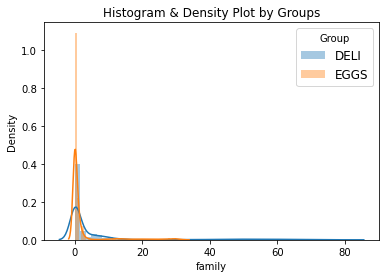

In [27]:
daliy_list = ['DELI', 'EGGS'] #2

for group in daliy_list:
  subset = train_data[train_data['family'] == group]

  sns.distplot(subset['onpromotion'],
              hist = True,
              label = group)
  
plt.title('Histogram & Density Plot by Groups')
plt.xlabel('family')
plt.ylabel('Density')
plt.legend(prop = {'size': 12}, title = 'Group')
plt.show()

#### cluster

(array([282810., 565620.,  56562., 452496., 169686., 452496., 226248.,
        226248., 509058., 113124.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ]),
 <BarContainer object of 10 artists>)

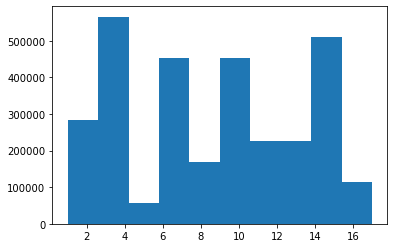

In [28]:
plt.hist(train_data.cluster)

In [29]:
train_data.cluster.unique()

array([13, 15,  6,  7,  3, 12, 16,  9,  1, 10,  8,  2,  4,  5, 11, 14, 17],
      dtype=int64)



---



In [30]:
train_data.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,type_y,cluster,Year,Month,Weekday,trend,NewYearsDay,no_work_day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,True
1,2013-01-01,1,BABY CARE,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,True
2,2013-01-01,1,BEAUTY,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,True
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,True
4,2013-01-01,1,BOOKS,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,True


일단은 다른 변수는 그대로 사용하기로 결정. 어떤게 유용할지 잘 감이 안옴. 변수를 다음과 같이 전처리

- 범주형 (다범주) : store_nbr, family, type_y
- 연속형(시간) : year, month, weekday, trend
- 연속형 : onpromotion, dcoilwtico, transactions,
- 범주형 순서 : cluster  
- 범주형 이진 : NewYearsDay, no_work_day

범주형(다범주)는 onehotencoding, 연속형(시간)은 그대로 사용, 연속형은 정규화, 범주형 순서는 그대로 사용(연속형), 범주형 이진은 bool로 변환

In [31]:
sub_train_data = train_data[train_data.date <= '2016-07-31']
valid_data = train_data[train_data.date >= '2016-08-01']

In [32]:
print(train_data.shape)
print(sub_train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(3054348, 15)
(2368278, 15)
(686070, 15)
(28512, 14)


In [33]:
# 검증 과정에서 사용할 데이터
sub_train_data.drop(columns = ['date'], inplace = True)
valid_data.drop(columns = ['date'], inplace = True)
# 최종 모델 훈련에서 사용할 데이터
train_data.drop(columns = ['date'], inplace = True)
test_data.drop(columns = ['date'], inplace = True)

In [34]:
X_sub_train_data = sub_train_data.drop(columns = ['sales'])
y_sub_train_data = sub_train_data['sales']

X_valid_data = valid_data.drop(columns = ['sales'])
y_valid_data = valid_data['sales']

#X_train_data = train_data.drop(columns = ['sales'])
#y_train_data = train_data['sales']

In [35]:
train_data.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico',
       'transactions', 'type_y', 'cluster', 'Year', 'Month', 'Weekday',
       'trend', 'NewYearsDay', 'no_work_day'],
      dtype='object')

In [36]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preproc = ColumnTransformer(
    [('standard', StandardScaler(), ['onpromotion', 'dcoilwtico', 'transactions']),
     ('cat', OneHotEncoder(sparse = False, drop = 'first'), ['store_nbr', 'family', 'type_y'])],
     remainder = 'passthrough')

preproc.fit(X_sub_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['onpromotion', 'dcoilwtico', 'transactions'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','no_work_day']])

X_sub_train_data_trans = pd.DataFrame(preproc.transform(X_sub_train_data), columns = labels)
X_valid_data_trans = pd.DataFrame(preproc.transform(X_valid_data), columns = labels)

##### LinearRegression

In [37]:
# modeling
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_sub_train_data_trans, y_sub_train_data)

LinearRegression()

In [38]:
train_pred = model.predict(X_sub_train_data_trans)
valid_pred = model.predict(X_valid_data_trans)

In [39]:
train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [40]:
from sklearn.metrics import mean_squared_log_error

In [41]:
mean_squared_log_error(y_sub_train_data, train_pred)

5.9946280685764135

In [42]:
mean_squared_log_error(y_valid_data, valid_pred)

5.334980286243024

#### Randomforest

In [44]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_sub_train_data_trans[-10000:], y_sub_train_data[-10000:])

RandomForestRegressor(min_samples_split=10)

In [45]:
#train_pred = rfmodel.predict(X_sub_train_data_trans)
valid_pred = rfmodel.predict(X_valid_data_trans)

In [46]:
#train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [47]:
#mean_squared_log_error(y_sub_train_data, train_pred)

In [48]:
mean_squared_log_error(y_valid_data, valid_pred)

0.753319570088643

## Test

In [49]:
X_train_data = train_data.drop(columns = ['sales'])
y_train_data = train_data['sales']

In [50]:
preproc.fit(X_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['onpromotion', 'dcoilwtico', 'transactions'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','no_work_day']])

X_train_data_trans = pd.DataFrame(preproc.transform(X_train_data), columns = labels)
X_test_data_trans = pd.DataFrame(preproc.transform(test_data), columns = labels)

In [51]:
rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_train_data_trans[-10000:], y_train_data[-10000:])

RandomForestRegressor(min_samples_split=10)

In [52]:
test_pred = rfmodel.predict(X_test_data_trans)

In [53]:
test_pred[test_pred < 0] = 0

In [54]:
submission = pd.read_csv('sample_submission.csv')

In [55]:
submission['sales'] = test_pred

In [56]:
submission.to_csv('submission.csv', index = False)